In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

[base1](https://medium.com/turing-talks/turing-talks-12-classifica%C3%A7%C3%A3o-por-svm-f4598094a3f1)

In [61]:
df = pd.read_csv('data\proposicoes_2013-2024_final_pres_cam.csv')
cols = [col for col in df.columns if col != 'VirouLei' and col != 'Partido_Pres_Cam'] + ['VirouLei'] + ['Partido_Pres_Cam']
df = df[cols]
df

,nomeProposicao,idProposicao,partidoAutor,DataApresentacao,Ano,Administração e Políticas Públicas,Desenvolvimento Social e Urbano,Direitos e Justiça,Economia e Desenvolvimento Sustentável,Infraestrutura e Gestão de Recursos,Influencia,Aliado,Oposição,PPC_igual_partidoAutor,VirouLei,Partido_Pres_Cam
0,PL 4926/2013,564574,PR,2013-02-04,2013,0,1,0,0,0,0.077973,1,0,0,0,PMDB
1,PL 4931/2013,564595,PR,2013-02-04,2013,1,1,0,0,1,0.024691,1,0,0,0,PMDB
2,PL 4928/2013,564579,PSB,2013-02-04,2013,0,1,0,0,0,0.025341,1,0,0,0,PMDB
3,PL 4936/2013,564610,PR,2013-02-05,2013,0,0,0,1,0,0.148148,1,0,0,0,PMDB
4,PL 4937/2013,564611,PSD,2013-02-05,2013,0,0,0,1,0,0.033138,1,0,0,0,PMDB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7956,PL 3027/2024,2450707,PT,2024-08-02,2024,0,0,0,1,1,0.097466,1,0,0,1,PP
7957,PL 3117/2024,2452037,PT,2024-08-13,2024,1,0,0,0,0,0.083821,1,0,0,1,PP
7958,PL 3148/2024,2452628,PSB,2024-08-13,2024,0,1,0,0,0,0.132554,1,0,0,1,PP
7959,PL 3266/2024,2454377,UNIÃO,2024-08-21,2024,0,1,0,1,0,0.011696,1,0,0,0,PP


- Destacando 2024

In [62]:
df_2024 = df[df['Ano'] == 2024]
df = df[df['Ano'] != 2024]

df_2024['VirouLei'].value_counts()

VirouLei
1    11
0     9
Name: count, dtype: int64

- Analise

In [63]:
colunas = df.columns.tolist()
colunas

x = df[colunas[5:-2]]
y = df[colunas[-2]]

x

,Administração e Políticas Públicas,Desenvolvimento Social e Urbano,Direitos e Justiça,Economia e Desenvolvimento Sustentável,Infraestrutura e Gestão de Recursos,Influencia,Aliado,Oposição,PPC_igual_partidoAutor
0,0,1,0,0,0,0.077973,1,0,0
1,1,1,0,0,1,0.024691,1,0,0
2,0,1,0,0,0,0.025341,1,0,0
3,0,0,0,1,0,0.148148,1,0,0
4,0,0,0,1,0,0.033138,1,0,0
...,...,...,...,...,...,...,...,...,...
7936,1,1,0,1,0,0.080078,0,1,0
7937,0,1,0,0,0,0.029297,1,0,0
7938,0,0,1,0,0,0.132812,1,0,0
7939,1,0,0,0,0,0.007812,1,0,0


- Undersampling

In [64]:
undersample = RandomUnderSampler(sampling_strategy=1.0) #para igualar as classes
#undersample = RandomUnderSampler(sampling_strategy=0.428) #70% 30%
#undersample = RandomUnderSampler(sampling_strategy=0.528)

x_sample, y_sample = undersample.fit_resample(x, y)

y_sample.value_counts()

VirouLei
0    757
1    757
Name: count, dtype: int64

In [65]:
indices_iguais = x_sample.index.equals(y_sample.index)
indices_iguais

True

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.3, random_state=42)

- SVM

In [67]:
kernels = ['linear', 'rbf', 'poly']
results = {}

for kernel in kernels:
    svc = SVC(kernel=kernel, gamma='auto') 
    cv_result = cross_val_score(svc, x_sample, y_sample, cv=10, scoring='accuracy')
    results[kernel] = cv_result.mean() * 100

print("Acurácia média com diferentes kernels:")
for kernel, score in results.items():
    print(f"{kernel}: {score:.2f}%")


Acurácia média com diferentes kernels:
linear: 59.18%
rbf: 61.49%
poly: 56.27%


In [68]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Melhores parâmetros para o kernel RBF:", grid_search.best_params_)
print("Acurácia média:", grid_search.best_score_)


Melhores parâmetros para o kernel RBF: {'C': 10, 'gamma': 'auto'}
Acurácia média: 0.613744075829384


In [77]:
#svc = SVC(gamma="auto", kernel="rbf", random_state=42)
svc = SVC(gamma="auto", class_weight='balanced', kernel="rbf", random_state=42)

svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print('Acuracia na prática:', svc.score(x_train, y_train))
print('Acuracia no teste:', svc.score(x_test, y_test))

Acuracia na prática: 0.619452313503305
Acuracia no teste: 0.6


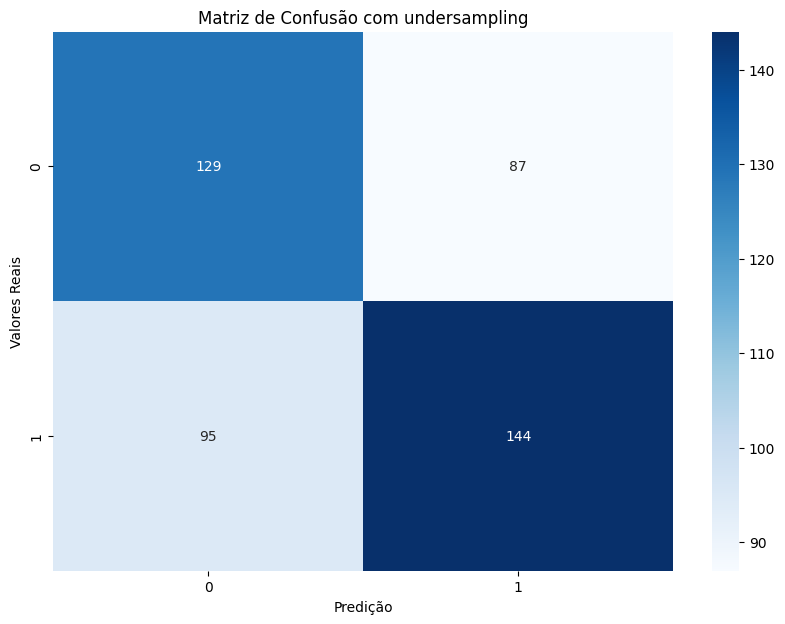

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predição')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão com undersampling')
plt.show()